# 1.  Preprocessing

In [172]:
import cv2
import numpy as np
from PIL import Image
import pytesseract

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

# preprocess cascade
def preprocess_img(test_img_name):
    test_img = cv2.imread(test_img_name)
    test_img = get_grayscale(test_img)
    test_img = remove_noise(test_img)
    test_img = thresholding(test_img)
    return test_img

# 2. test image from pytesseract 

git repo --> https://github.com/madmaze/pytesseract/blob/master/tests/data/test.png

In [164]:
def get_bounding_boxes(test_img):
    # get text
    img_text = pytesseract.image_to_string(test_img)

    # Get bounding box estimates
    bounding_boxes = pytesseract.image_to_boxes(test_img)

    # process bounding boxes
    bounding_boxes = bounding_boxes.split('\n')
    bounding_boxes = [v for v in bounding_boxes if len(v) > 0]
    bounding_box_entries = []
    for e in bounding_boxes:
        v = e.split(' ')
        entry = {}
        entry['character'] = v[0]
        entry['TL'] = v[1]
        entry['BL'] = v[2]
        entry['TR'] = v[3]
        entry['BR'] = v[4]
        bounding_box_entries.append(entry)

    return bounding_box_entries, img_text
    
    

# # Get verbose data including boxes, confidences, line and page numbers
# verbose_data = pytesseract.image_to_data(Image.open(test_img))

# # Get information about orientation and script detection
# orientation_data = pytesseract.image_to_osd(Image.open(test_img))

# # Get a searchable PDF
# pdf = pytesseract.image_to_pdf_or_hocr(test_img, extension='pdf')
# with open('test.pdf', 'w+b') as f:
#     f.write(pdf) # pdf type is bytes by default

---

Findings: default settings
- font size set at default value - how do we adjust?

- horizontal orientation

- recognize only black text on white background?  inverse?
    

---

In [165]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def markup_detected_img(test_img_name):
    # preprocess img
    test_img = preprocess_img(test_img_name)
    
    # get bounding box entries
    bounding_box_entries, img_text = get_bounding_boxes(test_img)

    for v in bounding_box_entries:
        x = eval(v['TL'])
        y = img.shape[0] - eval(v['BL'])
        h = eval(v['BR']) - eval(v['BL'])
        w = eval(v['TR']) - eval(v['TL'])
        character = v['character']

        # print bounding box and label on img
        test_img = cv2.rectangle(test_img, (x, y), (x + w, y - h), (36,255,12), 1)
        test_img = cv2.putText(test_img, character, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        
    # plot marked up image
    im_array = np.asarray(test_img)
    plt.imshow(im_array)
    plt.show()
    return img_text

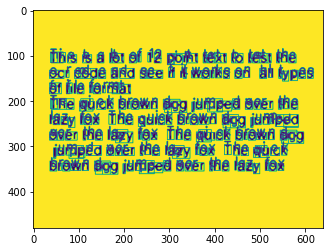

In [173]:
# define image
img_path = 'test_images'
img_name = 'test_1.png'
test_img_name = img_path + '/' + img_name
img_text = markup_detected_img(test_img_name)

In [174]:
print(img_text)

This ts a lot of 12 point text to test the
ocr code and see if it works on all types
of file format

The quick brown dog jumped over the
lazy fox The quick brown dog jumped
over the lazy fox The quick brown dog
jumped over the lazy fox The quick
brown dog jumped over the lazy fox

